In [27]:
import numpy as np
import sqlite3
import plotly.express as px
import pandas as pd
import sqlite3
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import statsmodels
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from useful_functions import *
from pdf2image import convert_from_path
from sklearn.manifold import TSNE

In [15]:
tables_to_join = ["tPlantNutrients", "tPlantDNA", "tSample"]
common_column = "sample_id"
full_df = import_all_data(tables_to_join, common_column)
full_df.shape

(158, 26)

In [16]:
full_df = full_df.T.drop_duplicates().T

In [17]:
full_df.head()

,sample_id,N_percent_dm,P_percent_dm,K_percent_dm,Ca_percent_dm,Mg_percent_dm,Na_percent_dm,S_percent_dm,Zn_ppm_dm,Mn_ppm_dm,...,V1,V2,species,PC1,PC2,PC3,PC4,PC5,site_id,collect_date
0,RRL1,NaN,0.21,4.01,0.83,0.29,0.01,0.37,29.0,281.0,...,0.753244,0.246756,exaltata,0.194769,0.048276,-0.02388,-0.017138,-0.039842,RRL,6/25/2021
1,RRL2,2.24,0.16,5.34,1.05,0.32,0.01,0.29,20.0,423.0,...,0.708412,0.291588,exaltata,0.154924,0.071277,0.000923,-0.02583,0.005592,RRL,6/25/2021
2,RRL3,NaN,0.2,4.75,0.63,0.27,0.04,0.22,21.0,469.0,...,0.778046,0.221954,exaltata,0.18775,0.035009,-0.016006,-0.012529,-0.011169,RRL,6/25/2021
3,RRL4,NaN,0.18,4.74,1.25,0.32,0.01,0.28,18.0,680.0,...,0.720367,0.279633,exaltata,0.167167,0.046053,-0.032754,-0.016192,-0.028988,RRL,6/25/2021
4,RRL5,3.0,0.26,3.51,1.2,0.44,0.01,0.29,29.0,507.0,...,0.572487,0.427513,exaltata,0.099801,0.0898,0.000613,-0.004979,0.017524,RRL,6/25/2021


In [18]:
df = full_df.copy()

In [19]:
leafNutrients = df.columns.drop(['sample_id','site_id','collect_date','V1', 'V2', 'species', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
print(leafNutrients)

Index(['N_percent_dm', 'P_percent_dm', 'K_percent_dm', 'Ca_percent_dm',
       'Mg_percent_dm', 'Na_percent_dm', 'S_percent_dm', 'Zn_ppm_dm',
       'Mn_ppm_dm', 'Fe_ppm_dm', 'Cu_ppm_dm', 'B_ppm_dm', 'Al_ppm_dm'],
      dtype='object')


In [20]:
df = df[df["species"].isin(['syriaca','exaltata'])]
df.shape

(154, 24)

In [21]:
site_list = df['site_id']

df['BGR'] = site_list

df['BGR'].replace({'CMB': 1, 'FRW': 1, 'LFS': 1, 'LM': 0, 'MMP': 1, 'MKP': 2,
                    'PNR': 2, 'PTW': 0, 'RF': 2, 'RGT': 0, 'RRL': 0, 'SGC': 0, 'SLG': 1,'HR': 3}, inplace=True) #
df = df[df["BGR"].isin([0,1,2,3])]

df['BGR'] = df['BGR'].replace([0], 'Wintergreen')
df['BGR'] = df['BGR'].replace([1], 'Cole Mountain')
df['BGR'] = df['BGR'].replace([2], 'Blacksburg')
df['BGR'] = df['BGR'].replace([3], 'HR')

In [22]:
df_nitrogen = df.copy()
df_dropped = df.copy()

In [23]:
df_nitrogen = df_nitrogen.dropna()
df_dropped = df_dropped.drop('N_percent_dm', axis = 1)

In [24]:
df_nitrogen[leafNutrients] = StandardScaler().fit_transform(df_nitrogen[leafNutrients])  

In [25]:
site_list = ['RRL', 'FRW', 'MMP', 'PNR', 'CMB', 'SLG', 'RF', 'LFS', 'PTW', 'LM', 'MKP', 'RGT']

# Predefined set of colors
unique_colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'pink', 'brown', 'gray', 'olive', 'lime', 'teal']

# Create a dictionary with list elements as keys and corresponding colors as values
site_color_dict = dict(zip(site_list, unique_colors))

print(site_color_dict)

{'RRL': 'red', 'FRW': 'green', 'MMP': 'blue', 'PNR': 'orange', 'CMB': 'purple', 'SLG': 'cyan', 'RF': 'pink', 'LFS': 'brown', 'PTW': 'gray', 'LM': 'olive', 'MKP': 'lime', 'RGT': 'teal'}


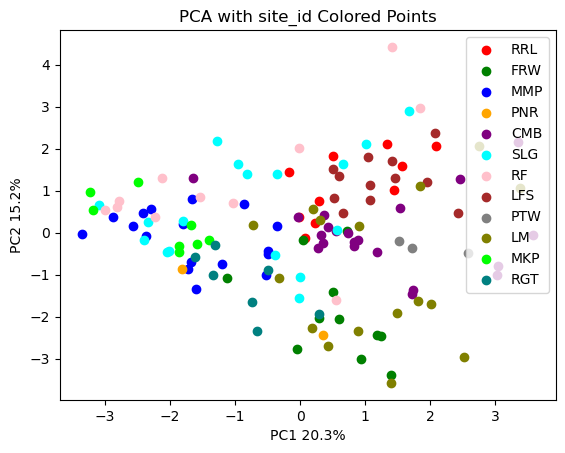

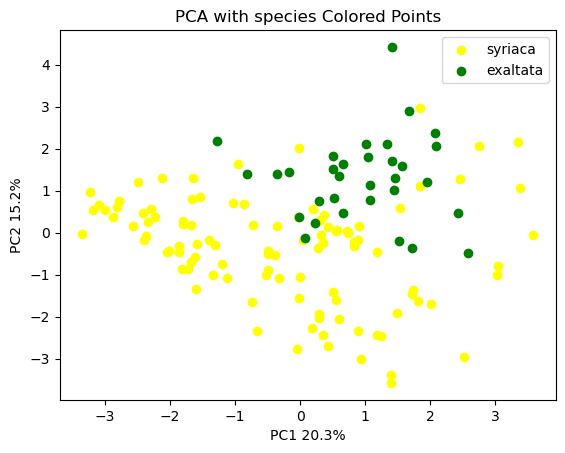

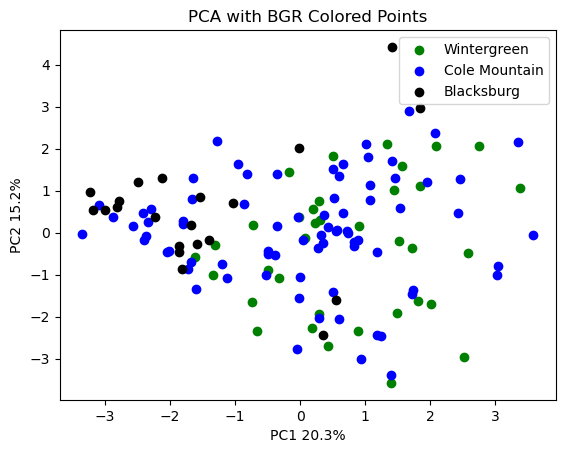

In [26]:
X = df_nitrogen[leafNutrients]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

for graph_type in ['site_id', 'species', 'BGR']:
    if graph_type == 'site_id':
        colors = site_color_dict
    elif graph_type == 'species':
        colors = {'syriaca': 'yellow', 'exaltata': 'green'}
    else:
        colors = {'Wintergreen': 'green', 'Cole Mountain': 'blue', 'Blacksburg': 'black'}
    
    fig, ax = plt.subplots()

    for key, color in colors.items():
        mask = (df_nitrogen[graph_type] == key)
        ax.scatter(
            principal_components[mask, 0],
            principal_components[mask, 1],
            c=color,
            label= key
        )
    
    ax.set_xlabel("PC1 " + str(round(100*pca.explained_variance_ratio_[0], 1)) + '%')
    ax.set_ylabel("PC2 " + str(round(100*pca.explained_variance_ratio_[1], 1)) + '%')
    ax.set_title('PCA with ' + graph_type + ' Colored Points')
    ax.legend()
    plt.show()
    if graph_type == 'site_id':
        ax.set_title('Sites and Leaf Nutrients')
        fig1 = fig
    elif graph_type == 'species':
        ax.set_title('Species and Leaf Nutrients')
        fig2 = fig
    else:
        ax.set_title('Broad Geographic Region and Leaf Nutrients')
        fig3 = fig

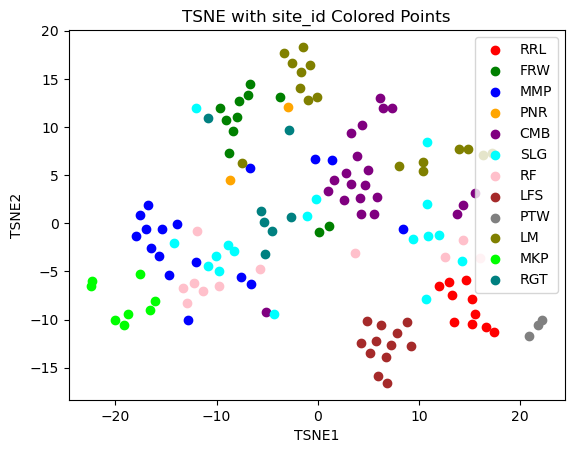

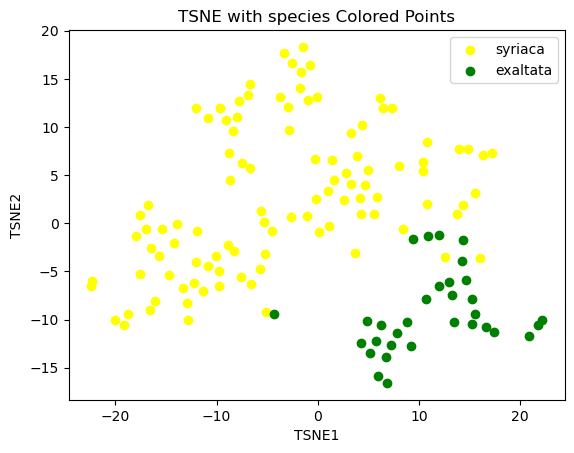

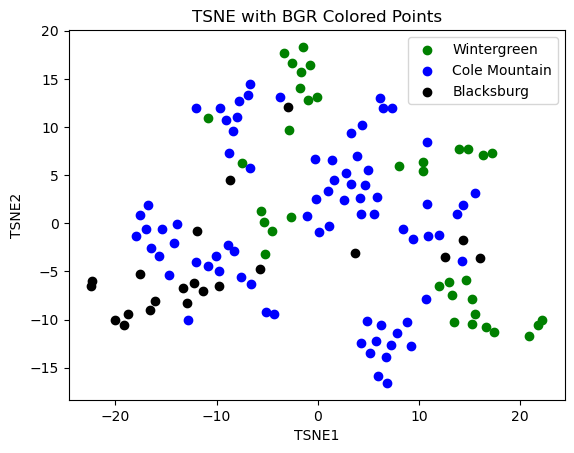

In [33]:
perplexity_value = 15 # Change this to your desired perplexity

tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
tsne_transformed = tsne.fit_transform(df_nitrogen[leafNutrients])


for graph_type in ['site_id', 'species', 'BGR']:
    if graph_type == 'site_id':
        colors = site_color_dict
    elif graph_type == 'species':
        colors = {'syriaca': 'yellow', 'exaltata': 'green'}
    else:
        colors = {'Wintergreen': 'green', 'Cole Mountain': 'blue', 'Blacksburg': 'black'}

    fig, ax = plt.subplots()

    for key, color in colors.items():
        mask = (df_nitrogen[graph_type] == key)
        ax.scatter(
            tsne_transformed[mask, 0],
            tsne_transformed[mask, 1],
            c=color,
            label= key
        )
    
    ax.set_xlabel("TSNE1")
    ax.set_ylabel("TSNE2")
    ax.set_title('TSNE with ' + graph_type + ' Colored Points')
    ax.legend()
    plt.show()

    if graph_type == 'site_id':
        ax.set_title('TSNE of Sites Perplexity Value = ' + str(perplexity_value))
        fig4 = fig
    elif graph_type == 'species':
        ax.set_title('TSNE of Species Perplexity Value = ' + str(perplexity_value))
        fig5 = fig
    else:
        ax.set_title('TSNE of Broad Geographic Region Perplexity Value = ' + str(perplexity_value))
        fig6 = fig

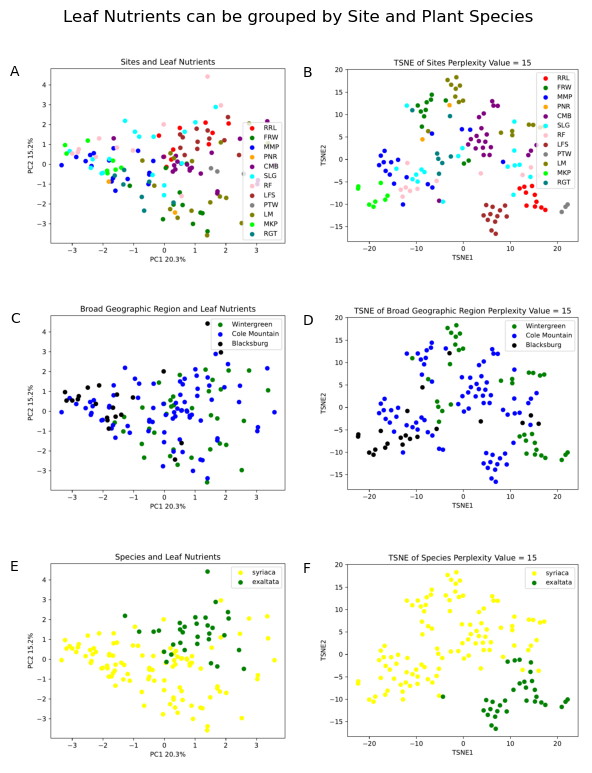

In [35]:
### Save Figures and Create Final Figure
fig1.savefig('leaf_nutrient_site_id.pdf', dpi=300, bbox_inches='tight')
fig2.savefig('leaf_nutrient_species.pdf', dpi=300, bbox_inches='tight')
fig3.savefig('leaf_nutrient_bgr.pdf', dpi=300, bbox_inches='tight')
fig4.savefig('leaf_nutrient_site_id_tsne.pdf', dpi=300, bbox_inches='tight')
fig5.savefig('leaf_nutrient_species_tsne.pdf', dpi=300, bbox_inches='tight')
fig6.savefig('leaf_nutrient_bgr_tsne.pdf', dpi=300, bbox_inches='tight')

img1=convert_from_path('leaf_nutrient_site_id.pdf')
img2=convert_from_path('leaf_nutrient_bgr.pdf')
img3=convert_from_path('leaf_nutrient_species.pdf')
img4=convert_from_path('leaf_nutrient_site_id_tsne.pdf')
img5=convert_from_path('leaf_nutrient_bgr_tsne.pdf')
img6=convert_from_path('leaf_nutrient_species_tsne.pdf')



fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))

ax[0][0].imshow(img1[0])
ax[0][1].imshow(img4[0])
ax[1][0].imshow(img2[0])
ax[1][1].imshow(img5[0])
ax[2][0].imshow(img3[0])
ax[2][1].imshow(img6[0])

# plot 2 subplots
ax[0][0].axis('off')
ax[0][1].axis('off')
ax[1][0].axis('off')
ax[1][1].axis('off')
ax[2][0].axis('off')
ax[2][1].axis('off')

ax[0][0].annotate("A", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[1][0].annotate("C", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[0][1].annotate("B", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[1][1].annotate("D", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[2][0].annotate("E", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[2][1].annotate("F", xy=(-0.05, 0.9), xycoords="axes fraction")


fig.suptitle('Leaf Nutrients can be grouped by Site and Plant Species')
plt.tight_layout()
plt.show()

fig.savefig('combined_leaf_nutrients.pdf', bbox_inches='tight', dpi = 1000)


In [36]:
leafNutrients = leafNutrients.drop('N_percent_dm')
df_dropped[leafNutrients] = StandardScaler().fit_transform(df_dropped[leafNutrients])  

In [37]:
site_list = ['RRL', 'FRW', 'MMP', 'PNR', 'CMB', 'SLG', 'RF', 'LFS', 'PTW', 'LM', 'MKP', 'RGT']

# Predefined set of colors
unique_colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'pink', 'brown', 'gray', 'olive', 'lime', 'teal']

# Create a dictionary with list elements as keys and corresponding colors as values
site_color_dict = dict(zip(site_list, unique_colors))

print(site_color_dict)

{'RRL': 'red', 'FRW': 'green', 'MMP': 'blue', 'PNR': 'orange', 'CMB': 'purple', 'SLG': 'cyan', 'RF': 'pink', 'LFS': 'brown', 'PTW': 'gray', 'LM': 'olive', 'MKP': 'lime', 'RGT': 'teal'}


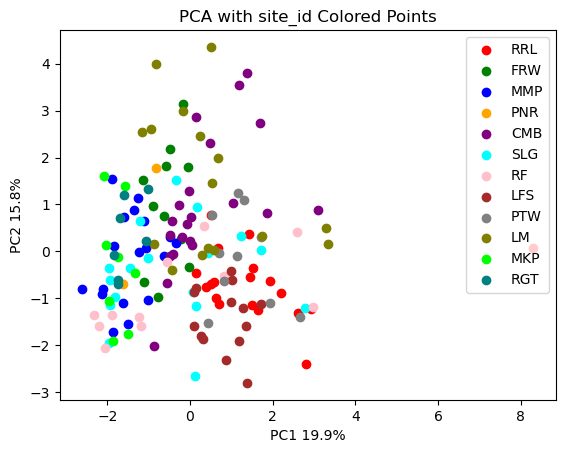

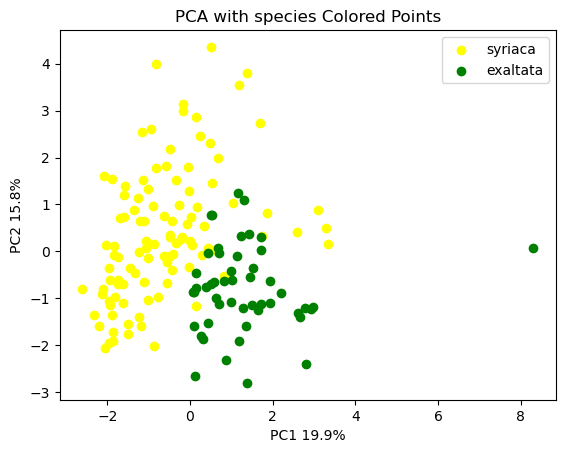

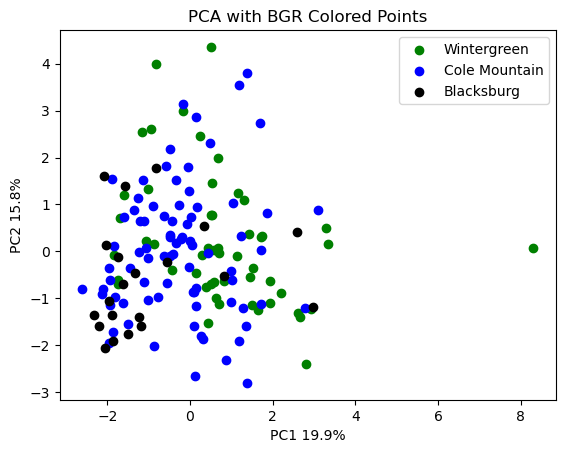

In [38]:
X = df_dropped[leafNutrients]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

for graph_type in ['site_id', 'species', 'BGR']:
    if graph_type == 'site_id':
        colors = site_color_dict
    elif graph_type == 'species':
        colors = {'syriaca': 'yellow', 'exaltata': 'green'}
    else:
        colors = {'Wintergreen': 'green', 'Cole Mountain': 'blue', 'Blacksburg': 'black'}
    
    fig, ax = plt.subplots()

    for key, color in colors.items():
        mask = (df_dropped[graph_type] == key)
        ax.scatter(
            principal_components[mask, 0],
            principal_components[mask, 1],
            c=color,
            label= key
        )
    
    ax.set_xlabel("PC1 " + str(round(100*pca.explained_variance_ratio_[0], 1)) + '%')
    ax.set_ylabel("PC2 " + str(round(100*pca.explained_variance_ratio_[1], 1)) + '%')
    ax.set_title('PCA with ' + graph_type + ' Colored Points')
    ax.legend()
    plt.show()
    if graph_type == 'site_id':
        ax.set_title('Sites and Leaf Nutrients')
        fig1 = fig
    elif graph_type == 'species':
        ax.set_title('Species and Leaf Nutrients')
        fig2 = fig
    else:
        ax.set_title('Broad Geographic Region and Leaf Nutrients')
        fig3 = fig

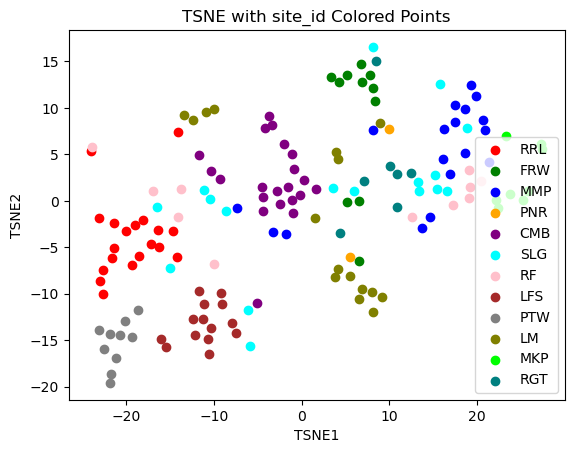

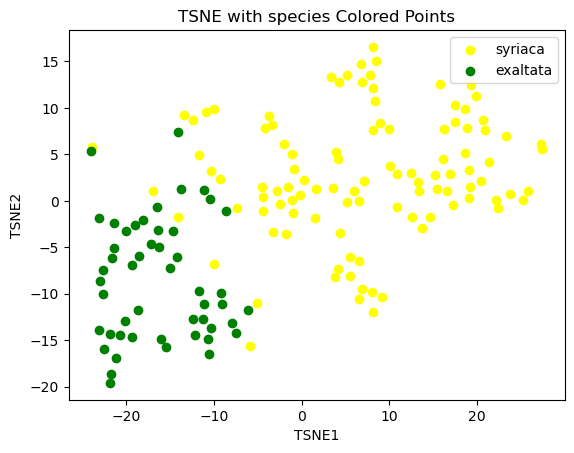

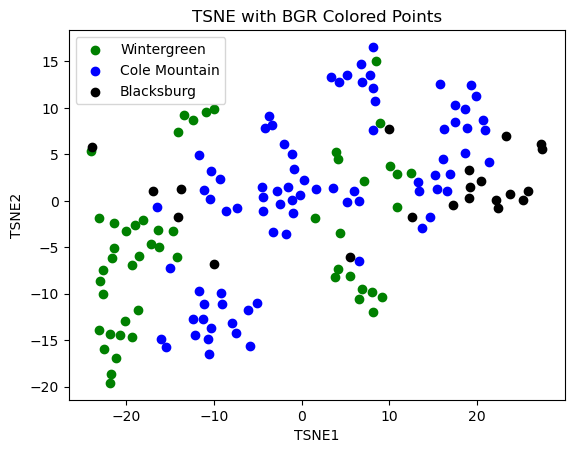

In [39]:
perplexity_value = 15 # Change this to your desired perplexity

tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
tsne_transformed = tsne.fit_transform(df_dropped[leafNutrients])


for graph_type in ['site_id', 'species', 'BGR']:
    if graph_type == 'site_id':
        colors = site_color_dict
    elif graph_type == 'species':
        colors = {'syriaca': 'yellow', 'exaltata': 'green'}
    else:
        colors = {'Wintergreen': 'green', 'Cole Mountain': 'blue', 'Blacksburg': 'black'}

    fig, ax = plt.subplots()

    for key, color in colors.items():
        mask = (df_dropped[graph_type] == key)
        ax.scatter(
            tsne_transformed[mask, 0],
            tsne_transformed[mask, 1],
            c=color,
            label= key
        )
    
    ax.set_xlabel("TSNE1")
    ax.set_ylabel("TSNE2")
    ax.set_title('TSNE with ' + graph_type + ' Colored Points')
    ax.legend()
    plt.show()

    if graph_type == 'site_id':
        ax.set_title('TSNE of Sites Perplexity Value = ' + str(perplexity_value))
        fig4 = fig
    elif graph_type == 'species':
        ax.set_title('TSNE of Species Perplexity Value = ' + str(perplexity_value))
        fig5 = fig
    else:
        ax.set_title('TSNE of Broad Geographic Region Perplexity Value = ' + str(perplexity_value))
        fig6 = fig

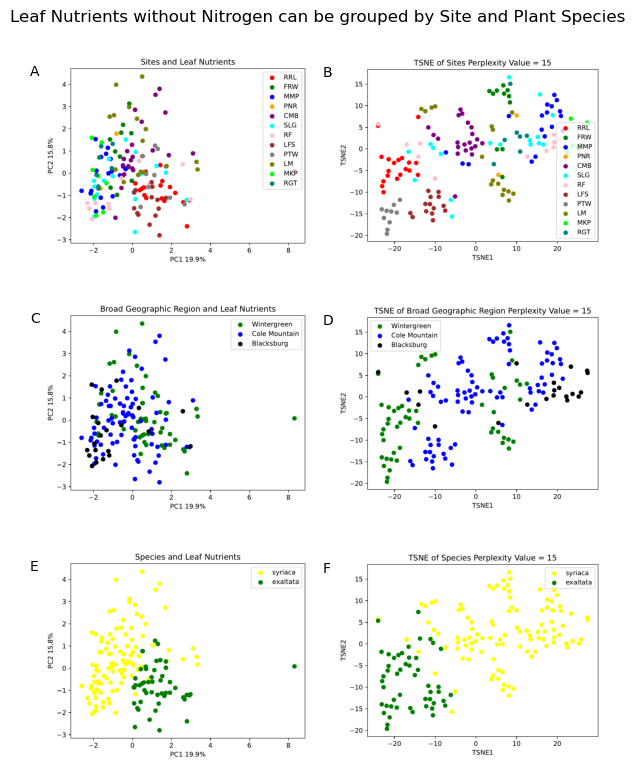

In [40]:
### Save Figures and Create Final Figure
fig1.savefig('leaf_nutrient_site_id_without_n.pdf', dpi=300, bbox_inches='tight')
fig2.savefig('leaf_nutrient_species_without_n.pdf', dpi=300, bbox_inches='tight')
fig3.savefig('leaf_nutrient_bgr_without_n.pdf', dpi=300, bbox_inches='tight')
fig4.savefig('leaf_nutrient_site_id_tsne_without_n.pdf', dpi=300, bbox_inches='tight')
fig5.savefig('leaf_nutrient_species_tsne_without_n.pdf', dpi=300, bbox_inches='tight')
fig6.savefig('leaf_nutrient_bgr_tsne_without_n.pdf', dpi=300, bbox_inches='tight')

img1=convert_from_path('leaf_nutrient_site_id_without_n.pdf')
img2=convert_from_path('leaf_nutrient_bgr_without_n.pdf')
img3=convert_from_path('leaf_nutrient_species_without_n.pdf')
img4=convert_from_path('leaf_nutrient_site_id_tsne_without_n.pdf')
img5=convert_from_path('leaf_nutrient_bgr_tsne_without_n.pdf')
img6=convert_from_path('leaf_nutrient_species_tsne_without_n.pdf')



fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))

ax[0][0].imshow(img1[0])
ax[0][1].imshow(img4[0])
ax[1][0].imshow(img2[0])
ax[1][1].imshow(img5[0])
ax[2][0].imshow(img3[0])
ax[2][1].imshow(img6[0])

# plot 2 subplots
ax[0][0].axis('off')
ax[0][1].axis('off')
ax[1][0].axis('off')
ax[1][1].axis('off')
ax[2][0].axis('off')
ax[2][1].axis('off')

ax[0][0].annotate("A", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[1][0].annotate("C", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[0][1].annotate("B", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[1][1].annotate("D", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[2][0].annotate("E", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[2][1].annotate("F", xy=(-0.05, 0.9), xycoords="axes fraction")


fig.suptitle('Leaf Nutrients without Nitrogen can be grouped by Site and Plant Species')
plt.tight_layout()
plt.show()

fig.savefig('leaf_nutrients_without_nitrogen.pdf', bbox_inches='tight', dpi = 1000)